# Load modules and functions

In [2]:
# Import modules
import numpy as np
import pandas as pd
import sklearn
from matplotlib import pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

import scipy
from scipy.sparse import csgraph
from numpy import linalg as LA

from collections import Counter

In [3]:
# Define functions
def compute_affinity_matrix(D, kernel_type, sigma=None, k=None):
    '''
    Construct an affinity matrix from a distance matrix via gaussian kernel.

    Inputs:
        D               a numpy array of size n x n containing the distances between points
        kernel_type     a string, either "gaussian" or "adaptive".
                            If kernel_type = "gaussian", then sigma must be a positive number
                            If kernel_type = "adaptive", then k must be a positive integer
        sigma           the non-adaptive gaussian kernel parameter
        k               the adaptive kernel parameter

    Outputs:
        W       a numpy array of size n x n that is the affinity matrix

    '''
    if kernel_type == "gaussian":
      assert sigma > 0, 'Sigma must be a positive number if kernel_type = "gaussian"'
      # Calculate Gaussian kernel
      W = np.exp(-D**2 / sigma**2)

    elif kernel_type == "adaptive":
      assert k > 0, 'k must be a positive integer if kernel_type = "adaptive"'
      # Define n as # rows of distance matrix
      n = D.shape[0]

      # Chunk to define sigma for each point (so we will have n different sigmas)
      # Initialize sigma
      sigma = np.zeros(n)
      # For each point, ...
      for i in range(n):
        # Determine indices that would sort distances from smallest (near) to largest (far)
        distance_order = np.argsort(D[i, :])
        # Determine the distance to the kth nearest neigbor...
        # by first getting index of kth nearest neighbor
        k_index = distance_order[k]
        # and pulling the distance value at this index to be sigma
        sigma[i] = D[i, k_index]

      # Chunk to calculate adaptive Gaussian kernel once sigma is calculated
      # Initialize W
      W = np.zeros((n, n))
      for i in range(n):
        for j in range(n):
          W[i, j] = 1/2 * (np.exp(-D[i, j]**2 / sigma[i]**2) + np.exp(-D[i, j]**2 / sigma[j]**2))

    # return the affinity matrix
    return W

def diff_map_info(W):
    '''
    Construct the information necessary to easily construct diffusion map for any t

    Inputs:
        W           a numpy array of size n x n containing the affinities between points

    Outputs:

        diff_vec    a numpy array of size n x n-1 containing the n-1 nontrivial eigenvectors of Markov matrix as columns
        diff_eig    a numpy array of size n-1 containing the n-1 nontrivial eigenvalues of Markov matrix

        We assume the convention that the coordinates in the diffusion vectors are in descending order
        according to eigenvalues.
    '''
    # Calculate D, i.e., the diagonal matrix of row sums
    n = W.shape[0]
    row_sums = W.sum(axis = 1)
    D = np.diag(row_sums)
    # Construct the symmetric Markov matrix M = D^(-1/2)WD^(-1/2)
    M = np.linalg.matrix_power(np.sqrt(D), -1) @ W @ np.linalg.matrix_power(np.sqrt(D), -1)
    # Compute eigenvalues and eigenvectors
    eigval, eigvec = np.linalg.eigh(M)
    # Get eigenvalue indices when arranged largest to smallest in order to...
    eigval_order = np.argsort(eigval)[::-1]
    # ... Rearrange eigenvalues and eigenvectors appropriately (i.e., PC1, PC2, ...)
    eigval = eigval[eigval_order]
    eigvec = eigvec[:, eigval_order]
    # Compute normalized eigenvectors of M as columns
    diff_vec = np.linalg.matrix_power(np.sqrt(D), -1) @ eigvec / np.linalg.norm(np.linalg.matrix_power(np.sqrt(D), -1) @ eigvec)
    # Compute eigenvalues
    diff_eig = eigval
    # Omit trivial eigenvector of M where eigenvalue is 1
    diff_eig = diff_eig[1:n]
    diff_vec = diff_vec[:, 1:n]

    # return the info for diffusion maps
    return diff_vec, diff_eig


def get_diff_map(diff_vec, diff_eig, t):
    '''
    Construct a diffusion map at t from eigenvalues and eigenvectors of Markov matrix

    Inputs:
        diff_vec    a numpy array of size n x n-1 containing the n-1 nontrivial eigenvectors of Markov matrix as columns
        diff_eig    a numpy array of size n-1 containing the n-1 nontrivial eigenvalues of Markov matrix
        t           diffusion time parameter t

    Outputs:
        diff_map    a numpy array of size n x n-1, the diffusion map defined for t
    '''
    # Construct diffusion map
    diff_map = diff_eig**t * diff_vec

    return diff_map

    # Sourced from Evan M. Yu
# https://github.com/evanmy/graph_clustering/blob/master/tools.py
def eigenDecomposition(A, plot = True, topK = 10):
    """
    :param A: Affinity matrix
    :param plot: plots the sorted eigen values for visual inspection
    :return A tuple containing:
    - the optimal number of clusters by eigengap heuristic
    - all eigen values
    - all eigen vectors

    This method performs the eigen decomposition on a given affinity matrix,
    following the steps recommended in the paper:
    1. Construct the normalized affinity matrix: L = D−1/2ADˆ −1/2.
    2. Find the eigenvalues and their associated eigen vectors
    3. Identify the maximum gap which corresponds to the number of clusters
    by eigengap heuristic

    References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf
    """
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]

    # LM parameter : Eigenvalues with largest magnitude (eigs, eigsh), that is, largest eigenvalues in
    # the euclidean norm of complex numbers.
#     eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
    eigenvalues, eigenvectors = LA.eig(L)

    if plot:
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.grid()

    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:topK]
    nb_clusters = index_largest_gap + 1

    return nb_clusters, eigenvalues, eigenvectors

# Spectral clustering - functional connectivity (FC)

In [4]:
# Load functional connectivity matrix (690 x 690)
# Convert to matrix and scale
# generated from compute_connectivities.Rmd
fc_df = pd.read_csv("../data/connectivity/functional_connectivity_neurosynth.csv")
fc_matrix = fc_df.to_numpy()
min_max_scaler = preprocessing.MinMaxScaler()
fc_matrix_scaled = min_max_scaler.fit_transform(fc_matrix)

Optimal number of clusters [ 1  2  3 37  5  6 46 54  7 62]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


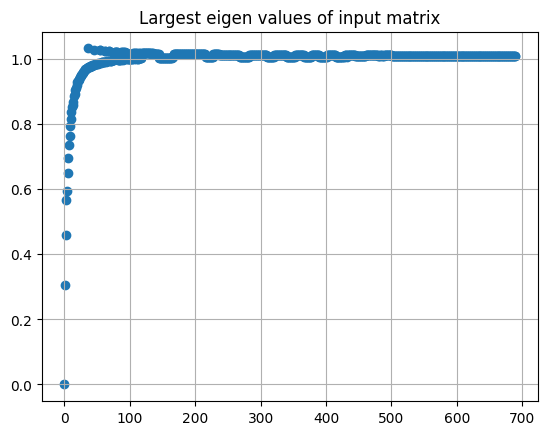

In [5]:
# Perform eigendecomposition to identify the optimal number of clusters 
# as the index corresponding to the larger gap between eigenvalues
k, _,  _ = eigenDecomposition(fc_matrix_scaled)
print(f'Optimal number of clusters {k}')

In [6]:
# Perform spectral clustering with 5 clusters (i.e., same # as FC)
fc_spec_clust = cluster.SpectralClustering(n_clusters=5,
                                           affinity="precomputed",
                                           assign_labels = "discretize",
                                           random_state = 0
                                           )
fc_spec_clust_results = fc_spec_clust.fit_predict(fc_matrix_scaled)
#fc_spec_clust_results.shape
#plt.hist(fc_spec_clust_results, density=False)  # density=False would make counts
#plt.ylabel('Count')
#plt.xlabel('Data')
#ind = np.arange(690)
#fig = plt.figure()
#fig.set_size_inches(12, 12)
#ax = fig.add_axes([0,0,1,1])
#ax.bar(ind[0:345], fc_spec_clust_results[0:345], color='b')
#ax.set_ylabel('Cluster')
#plt.show()

# Create dataframe as save as csv
fc_spec_clust_results_df = pd.DataFrame(fc_spec_clust_results, columns=['spectral_cluster'])
fc_spec_clust_results_df.to_csv("../data/connectivity/fc_spectral_clustering_results.csv", index = False)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


In [39]:
# Now, we will create the diffusion map componenents based on FC
fc_diff_vec, fc_diff_eig = diff_map_info(fc_matrix_scaled)
fc_diff_map = get_diff_map(fc_diff_vec, fc_diff_eig, 1)
fc_diff_map_df = pd.DataFrame({"fc_diff1": -1*fc_diff_map[:,0], # invert FC diffusion 1 (simply for aesthetic reasons)
                               "fc_diff2": fc_diff_map[:,1]
                               })
# Save dataframe as csv
fc_diff_map_df.to_csv("../data/connectivity/fc_diffusion.csv", index = False)

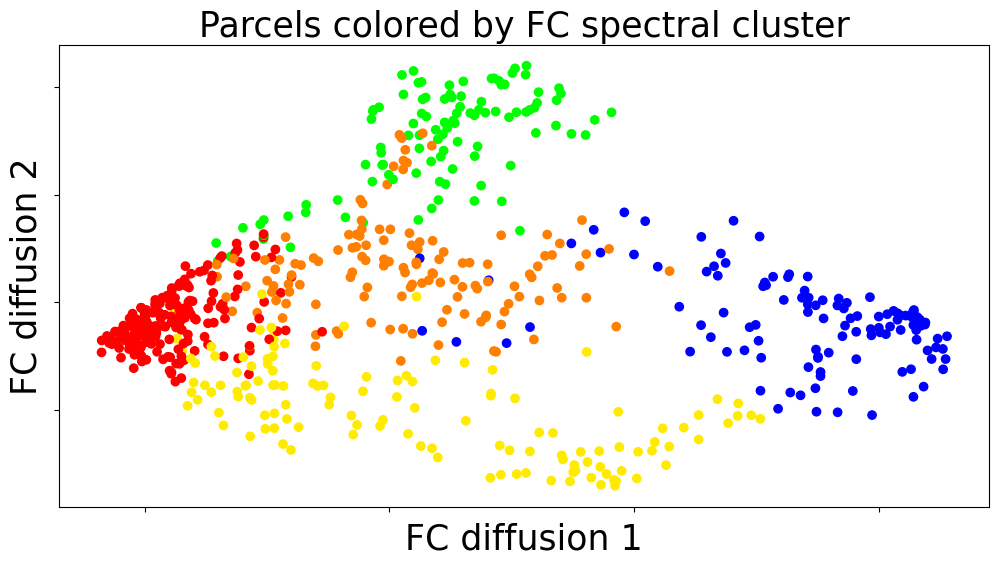

In [40]:
# Now, plot FC spectral clusters along diffusion components derived from FC

# Assign colors (ROYGBIV) based on FC spectral cluster designation
fc_spec_clust_color_df = []
for i in range(fc_spec_clust_results_df.shape[0]):
  if fc_spec_clust_results_df['spectral_cluster'][i] == 0:
    fc_spec_clust_color_df.append((255/255, 0/255, 0/255))
  if fc_spec_clust_results_df['spectral_cluster'][i] == 1:
    fc_spec_clust_color_df.append((255/255, 127/255, 0/255))
  if fc_spec_clust_results_df['spectral_cluster'][i] == 2:
    fc_spec_clust_color_df.append((255/255, 235/255, 0/255))
  if fc_spec_clust_results_df['spectral_cluster'][i] == 3:
    fc_spec_clust_color_df.append((0/255, 255/255, 0/255))
  if fc_spec_clust_results_df['spectral_cluster'][i] == 4:
    fc_spec_clust_color_df.append((0/255, 0/255, 255/255))

# Plot
fig = plt.figure(figsize=[12,6])
plt.scatter(fc_diff_map_df["fc_diff1"], fc_diff_map_df["fc_diff2"], color = fc_spec_clust_color_df)
plt.xlabel('FC diffusion 1', fontsize = 25)
plt.ylabel('FC diffusion 2', fontsize = 25)
plt.locator_params(nbins=6)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
plt.title("Parcels colored by FC spectral cluster", fontsize = 25)
fig.savefig("../figures/subplots/fig2_fc_diffmap_fc_spec_clust.png", format='png', dpi=300, bbox_inches="tight")

# Spectral clustering - structural connectivity (SC)

In [15]:
# Load structural connectivity matrix (690 x 690)
# Convert to matrix
# generated from compute_connectivities.Rmd
sc_df = pd.read_csv("../data/connectivity/structural_connectivity_wmpaths.csv")
sc_matrix = sc_df.to_numpy()

Optimal number of clusters [ 16  64  68  78  82  89  95  98 102 142]


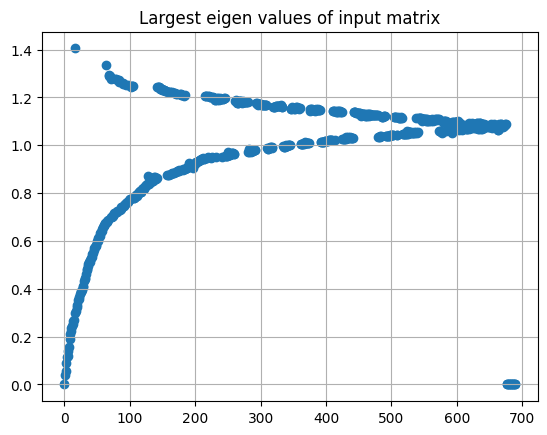

In [16]:
# Perform eigendecomposition to identify the optimal number of clusters 
# as the index corresponding to the larger gap between eigenvalues
k, _,  _ = eigenDecomposition(sc_matrix)
print(f'Optimal number of clusters {k}')

In [17]:
# Perform spectral clustering with 5 clusters
sc_spec_clust = cluster.SpectralClustering(n_clusters=5,
                                           affinity="cosine",
                                           assign_labels = "kmeans",
                                           random_state = 0
                                           )
sc_spec_clust_results = sc_spec_clust.fit_predict(sc_matrix)
#sc_spec_clust_results.shape
#plt.hist(sc_spec_clust_results, density=False)  # density=False would make counts
#plt.ylabel('Count')
#plt.xlabel('Data')
#ind = np.arange(690)
#fig = plt.figure()
#fig.set_size_inches(12, 12)
#ax = fig.add_axes([0,0,1,1])
#ax.bar(ind[0:345], sc_spec_clust_results[0:345], color='b')
#ax.set_ylabel('Cluster')
#plt.show()

# Create dataframe as save as csv
sc_spec_clust_results_df = pd.DataFrame(sc_spec_clust_results, columns=['spectral_cluster'])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [50]:
# Rearrange SC spectral clusters to optimally align with FC spectral clusters
# Find the cluster designation in the second list that overlaps the most with 
# each specific cluster designation in the first list.
overlap_counts = {0: Counter(), 1: Counter(), 2: Counter(), 3: Counter(), 4: Counter()}
# Iterate through both cluster designation lists and count overlaps
for cluster1, cluster2 in zip(fc_spec_clust_results_df['spectral_cluster'], sc_spec_clust_results_df['spectral_cluster']):
    overlap_counts[cluster1][cluster2] += 1

# Find the most overlapping cluster for each value in the first list
most_overlapping_clusters = {cluster: counts.most_common(1)[0][0] for cluster, counts in overlap_counts.items()}

print(most_overlapping_clusters)

{0: 2, 1: 1, 2: 2, 3: 0, 4: 4}


In [18]:
# Reassign SC cluster 0 to 3
sc_spec_clust_results_df['new_spectral_cluster'] = sc_spec_clust_results_df['spectral_cluster']
sc_spec_clust_results_df['new_spectral_cluster'] = sc_spec_clust_results_df['new_spectral_cluster'].replace(0, 10) # temporary

# Reassign SC cluster 3 to 0
sc_spec_clust_results_df['new_spectral_cluster'] = sc_spec_clust_results_df['new_spectral_cluster'].replace(3, 0)
sc_spec_clust_results_df['new_spectral_cluster'] = sc_spec_clust_results_df['new_spectral_cluster'].replace(10, 3)

# Reassign SC cluster 2 to 0
sc_spec_clust_results_df['new_spectral_cluster'] = sc_spec_clust_results_df['new_spectral_cluster'].replace(2, 10) # temporary

# Reassign SC cluster 0 to 2
sc_spec_clust_results_df['new_spectral_cluster'] = sc_spec_clust_results_df['new_spectral_cluster'].replace(0, 2)
sc_spec_clust_results_df['new_spectral_cluster'] = sc_spec_clust_results_df['new_spectral_cluster'].replace(10, 0)

# Save as csv
sc_spec_clust_results_df.to_csv("../data/connectivity/sc_spectral_clustering_results.csv", index = False)

# Rearrange SC spectral clusters to optimally align with FC spectral clusters
# Find the cluster designation in the second list that overlaps the most with 
# each specific cluster designation in the first list.
#overlap_counts = {0: Counter(), 1: Counter(), 2: Counter(), 3: Counter(), 4: Counter()}
# Iterate through both cluster designation lists and count overlaps
#for cluster1, cluster2 in zip(fc_spec_clust_results_df['spectral_cluster'], sc_spec_clust_results_df['new_spectral_cluster']):
#    overlap_counts[cluster1][cluster2] += 1

# Find the most overlapping cluster for each value in the first list
#most_overlapping_clusters = {cluster: counts.most_common(1)[0][0] for cluster, counts in overlap_counts.items()}

#print(most_overlapping_clusters)


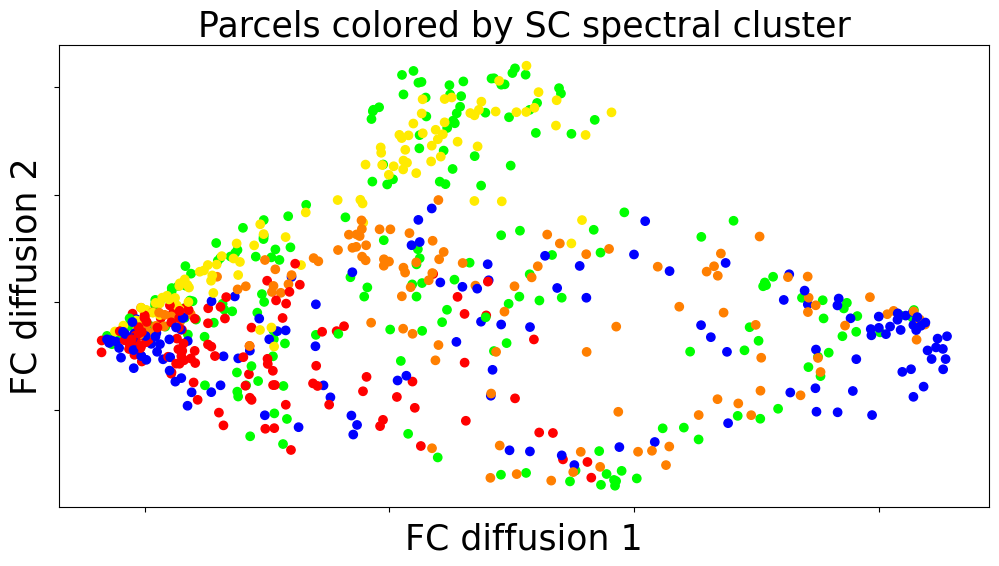

In [45]:
# Now, plot SC spectral clusters along diffusion components derived from FC

# Assign colors (ROYGBIV) based on SC spectral cluster designation
sc_spec_clust_color_df = []
for i in range(sc_spec_clust_results_df.shape[0]):
  if sc_spec_clust_results_df['new_spectral_cluster'][i] == 0:
    sc_spec_clust_color_df.append((255/255, 0/255, 0/255))
  if sc_spec_clust_results_df['new_spectral_cluster'][i] == 1:
    sc_spec_clust_color_df.append((255/255, 127/255, 0/255))
  if sc_spec_clust_results_df['new_spectral_cluster'][i] == 2:
    sc_spec_clust_color_df.append((255/255, 235/255, 0/255))
  if sc_spec_clust_results_df['new_spectral_cluster'][i] == 3:
    sc_spec_clust_color_df.append((0/255, 255/255, 0/255))
  if sc_spec_clust_results_df['new_spectral_cluster'][i] == 4:
    sc_spec_clust_color_df.append((0/255, 0/255, 255/255))

# Plot
fig = plt.figure(figsize=[12,6])
plt.scatter(fc_diff_map_df["fc_diff1"], fc_diff_map_df["fc_diff2"], color = sc_spec_clust_color_df)
plt.xlabel('FC diffusion 1', fontsize = 25)
plt.ylabel('FC diffusion 2', fontsize = 25)
plt.locator_params(nbins=6)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
plt.title("Parcels colored by SC spectral cluster", fontsize = 25)
fig.savefig("../figures/subplots/fig2_fc_diffmap_sc_spec_clust.png", format='png', dpi=300, bbox_inches="tight")

# FC diffusion map of parcels colored by axial, sagittal, and coronal coordinates

In [6]:
# Load in parcel dictionary dataframe that has mean x, y, and z coordinates by parcel
parcel_dict = pd.read_csv("../data/misc/parcel_dict.csv")
fc_diff_map_df = pd.read_csv("../data/connectivity/fc_diffusion.csv")

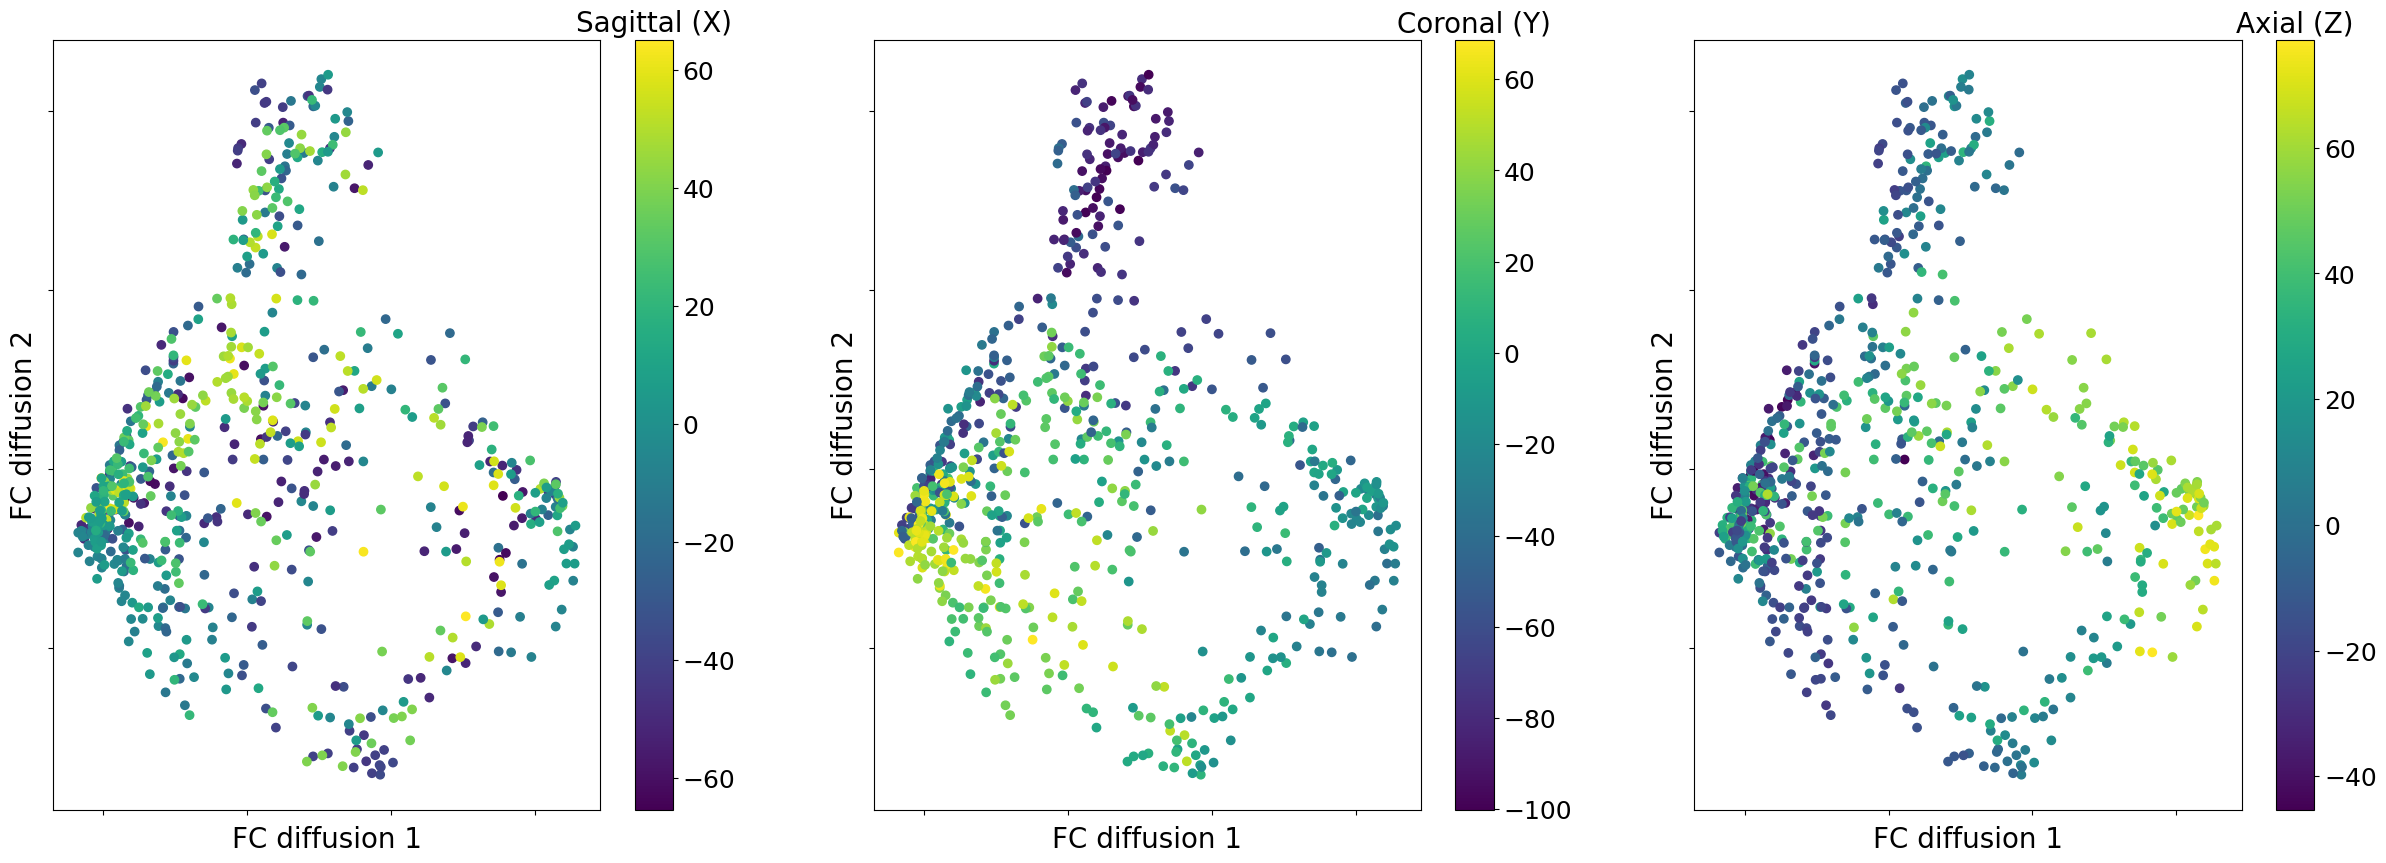

In [8]:
# Plot FC diffusion map with parcels colored by sagittal, coronal, and axial dimensions

fig = plt.figure(figsize=[30,10])
# Sagittal
plt.subplot(1,3,1)
plt.scatter(fc_diff_map_df["fc_diff1"], fc_diff_map_df["fc_diff2"], c = parcel_dict['mean_x'])
plt.xlabel('FC diffusion 1', fontsize = 20)
plt.ylabel('FC diffusion 2', fontsize = 20)
clb = plt.colorbar()
clb.ax.set_title('Sagittal (X)', fontsize = 20)
clb.ax.tick_params(labelsize=18)
plt.locator_params(nbins=6)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
# Coronal
plt.subplot(1,3,2)
plt.scatter(fc_diff_map_df["fc_diff1"], fc_diff_map_df["fc_diff2"], c = parcel_dict['mean_y'])
plt.xlabel('FC diffusion 1', fontsize = 20)
plt.ylabel('FC diffusion 2', fontsize = 20)
clb = plt.colorbar()
clb.ax.set_title('Coronal (Y)', fontsize = 20)
clb.ax.tick_params(labelsize=18)
plt.locator_params(nbins=6)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
# Axial
plt.subplot(1,3,3)
plt.scatter(fc_diff_map_df["fc_diff1"], fc_diff_map_df["fc_diff2"], c = parcel_dict['mean_z'])
plt.xlabel('FC diffusion 1', fontsize = 20)
plt.ylabel('FC diffusion 2', fontsize = 20)
clb = plt.colorbar()
clb.ax.set_title('Axial (Z)', fontsize = 20)
clb.ax.tick_params(labelsize=18)
plt.locator_params(nbins=6)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
fig.savefig('../figures/subplots/supp_fc_diffmap_xyz.png', format='png', dpi=300)